<a href="https://colab.research.google.com/github/priyank21112000/Deep-Learning-using-Pytorch/blob/main/Satellite_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Satellite Images Classification using CNN

It covers the following topics:


*   Importing the Dataset using opendatasets
*   Splitting the data into training, validation and test sets
*   Defining the Convolutional Neural Network
*   Moving the model and data to GPU
*   Training the Model with fit and evaluate functions
*   Testing with individual images and calculating accuracy




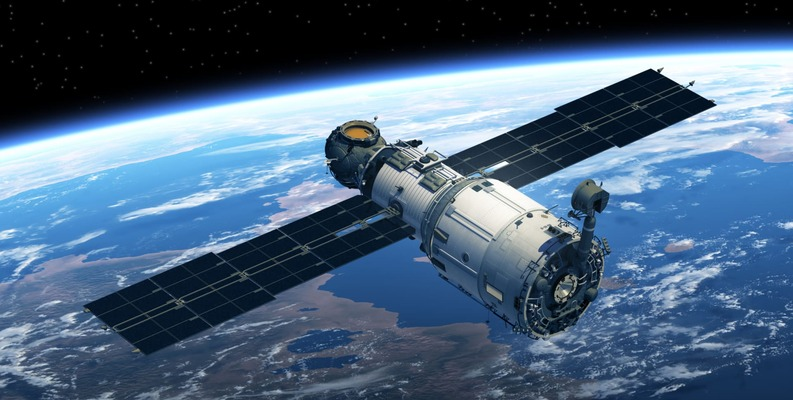

We will use the Satellite Image Classification Dataset comprising 5631 images categorized into four distinct classes: cloudy, desert, green_area, and water. [Source](https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification)



In [61]:
#Importing necessary libraries
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## Loading the Dataset

In [3]:
!pip install opendatasets --upgrade --quiet

In [4]:
import opendatasets as od

In [6]:
od.download('https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification?resource=download')

100%|██████████| 21.8M/21.8M [00:00<00:00, 56.0MB/s]


Dataset contains 4 classes - cloudy, desert, green area, water

In [7]:
data_dir = './satellite-image-classification'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/data")
print(classes)

['data']
['desert', 'water', 'cloudy', 'green_area']


Calculating the number of images in each class

In [8]:
cloudy_files = os.listdir(data_dir + "/data/cloudy")
print('No. of training examples for clouds:', len(cloudy_files))
print(cloudy_files[:5])

No. of training examples for clouds: 1500
['train_18150.jpg', 'train_1500.jpg', 'train_6573.jpg', 'train_8544.jpg', 'train_32320.jpg']


In [9]:
desert_files = os.listdir(data_dir + "/data/desert")
print('No. of training examples for clouds:', len(desert_files))
print(desert_files[:5])

No. of training examples for clouds: 1131
['desert(255).jpg', 'desert(249).jpg', 'desert(693).jpg', 'desert(769).jpg', 'desert(290).jpg']


In [10]:
green_area_files = os.listdir(data_dir + "/data/green_area")
print('No. of training examples for green area:', len(green_area_files))
print(green_area_files[:5])

No. of training examples for green area: 1500
['Forest_930.jpg', 'Forest_315.jpg', 'Forest_452.jpg', 'Forest_757.jpg', 'Forest_627.jpg']


In [11]:
water_files = os.listdir(data_dir + "/data/water")
print('No. of training examples for water:', len(water_files))
print(water_files[:5])

No. of training examples for water: 1500
['SeaLake_552.jpg', 'SeaLake_2428.jpg', 'SeaLake_400.jpg', 'SeaLake_1998.jpg', 'SeaLake_1344.jpg']


In [12]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

Changing the image size to 64x64 pixels

In [13]:
from torchvision import datasets, transforms
desired_size = (64, 64)

transform = transforms.Compose([
    transforms.Resize(desired_size),
    transforms.ToTensor()
])

dataset = ImageFolder(data_dir+'/data', transform=transform)

In [14]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 64, 64]) 0


tensor([[[0.6039, 0.6314, 0.6196,  ..., 0.7725, 0.7882, 0.8000],
         [0.6157, 0.6275, 0.6157,  ..., 0.7569, 0.7765, 0.7843],
         [0.6196, 0.6235, 0.6275,  ..., 0.7451, 0.7608, 0.7725],
         ...,
         [0.8863, 0.8863, 0.8863,  ..., 0.5804, 0.5843, 0.5922],
         [0.8863, 0.8863, 0.8863,  ..., 0.5804, 0.5804, 0.5882],
         [0.8863, 0.8863, 0.8863,  ..., 0.5725, 0.5725, 0.5804]],

        [[0.5843, 0.6039, 0.5882,  ..., 0.7529, 0.7686, 0.7804],
         [0.5961, 0.6000, 0.5922,  ..., 0.7373, 0.7569, 0.7647],
         [0.5922, 0.5961, 0.6000,  ..., 0.7333, 0.7451, 0.7529],
         ...,
         [0.8039, 0.8039, 0.8039,  ..., 0.5961, 0.6000, 0.6000],
         [0.8039, 0.8039, 0.8039,  ..., 0.5922, 0.5961, 0.6000],
         [0.8039, 0.8039, 0.8039,  ..., 0.5922, 0.5922, 0.5961]],

        [[0.4902, 0.5098, 0.4980,  ..., 0.6745, 0.6902, 0.7020],
         [0.5020, 0.5059, 0.5020,  ..., 0.6588, 0.6745, 0.6902],
         [0.5059, 0.5020, 0.5098,  ..., 0.6471, 0.6627, 0.

The data consists of 64x64 px color images with 3 channels (RGB), each image tensor has the shape (3, 64, 64).

In [15]:
print(dataset.classes)

['cloudy', 'desert', 'green_area', 'water']


The list of classes is stored in the .classes property of the dataset.

## Training and Validation Datasets

Splitting the dataset into training, validation and test sets

In [16]:
random_seed = 30
torch.manual_seed(random_seed);

In [17]:
val_size = 700
test_size = 900
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(4031, 700, 900)

In [62]:
from torch.utils.data.dataloader import DataLoader
batch_size=128

Creating data loaders to load the data in batches

In [19]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [20]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [22]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Change the tensor dimensions to (64, 64, 3) for viewing it in Matplotlib

Label:  cloudy (0)


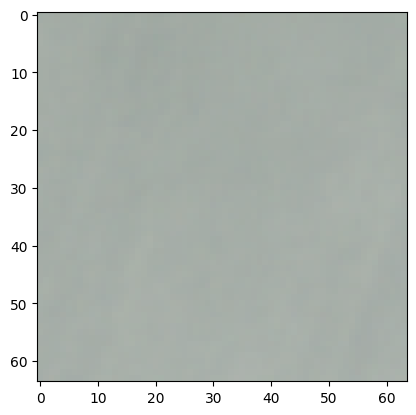

In [23]:
show_example(*dataset[1])

Label:  cloudy (0)


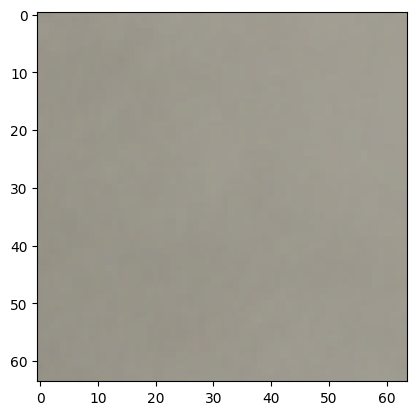

In [24]:
show_example(*dataset[3])

Label:  desert (1)


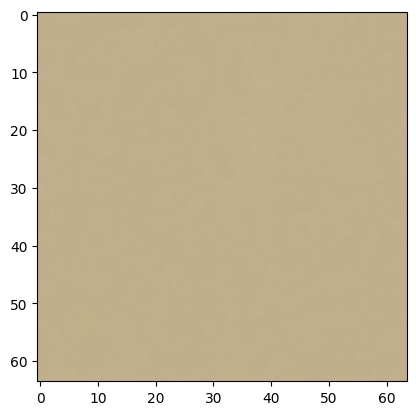

In [25]:
show_example(*dataset[2345])

In [26]:
import torch.nn as nn
import torch.nn.functional as F

Using the make_grid method from torchvision to look at batches of images from the dataset. Each time the following code is run, we get a different batch, since the sampler shuffles the indices before creating batches.

images.shape: torch.Size([128, 3, 64, 64])


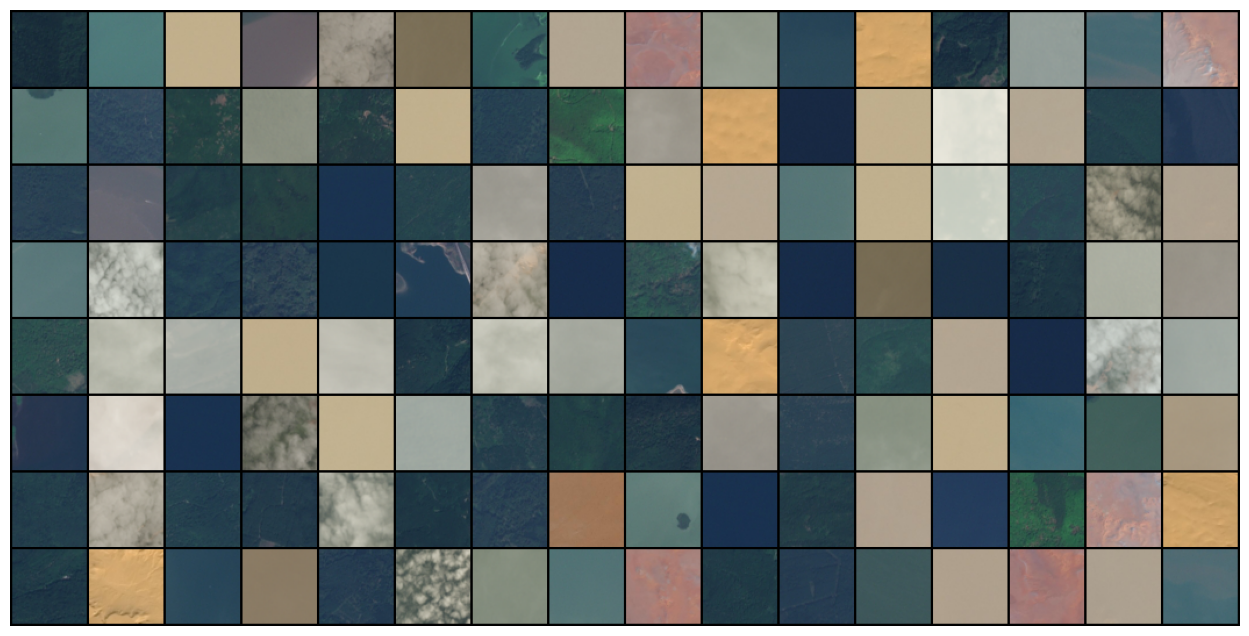

In [27]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

Before defining the entire model, let's look at how a single convolutional layer followed by a max-pooling layer operates on the data.



In [28]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

Example showing how 3 channel images are converted to 8 channels

In [29]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([128, 3, 64, 64])
out.shape: torch.Size([128, 8, 32, 32])


## Defining the Model (Convolutional Neural Network)

A Convolutional Neural Network (CNN) is a type of artificial neural network specifically designed for processing and analyzing visual data, such as images and videos. It is inspired by the human visual system and is highly effective in tasks like image recognition, object detection, and image classification.

A CNN works by learning and extracting meaningful patterns or features from images. It does this through a series of specialized layers, including convolutional layers, pooling layers, and fully connected layers.

In [31]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


*   The Conv2d layer transforms a 3-channel image to a feature map, and the MaxPool2d layer halves the height and width. The feature map gets smaller as we add more layers, until we are finally left with a small feature map, which can be flattened into a vector. We can then add some fully connected layers at the end to get vector of size 4 for each image.

*   Use nn.Sequential to chain the layers and activations functions into a single network architecture.



In [32]:
class SatelliteClassificationModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(256*8*8, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 4))

    def forward(self, xb):
        return self.network(xb)

Initializing the model

In [33]:
model = SatelliteClassificationModel()
model

SatelliteClassificationModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=16384, out_features=1024, bias=True)
    (17): ReLU()
    (18): 

In [34]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 64, 64])
out.shape: torch.Size([128, 4])
out[0]: tensor([-0.0397, -0.0044,  0.0103, -0.0247], grad_fn=<SelectBackward0>)


## Using GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (get_default_device & to_device) and a helper class DeviceDataLoader to move our model & data to the GPU as required.

In [35]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [36]:
device = get_default_device()
device

device(type='cuda')

In [37]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

## Training the Model

Define two functions: fit and evaluate to train the model using gradient descent and evaluate its performance on the validation set.

In [38]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before training, let's instantiate the model once again and see how it performs on the validation set with the initial set of parameters.

In [39]:
model = to_device(SatelliteClassificationModel(), device)

In [40]:
evaluate(model, val_dl)

{'val_loss': 1.384968638420105, 'val_acc': 0.26645612716674805}

We'll use the following hyperparmeters (learning rate, no. of epochs, batch_size etc.) to train our model.



In [41]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [42]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.9153, val_loss: 0.7094, val_acc: 0.4888
Epoch [1], train_loss: 0.6877, val_loss: 0.5129, val_acc: 0.6963
Epoch [2], train_loss: 0.5249, val_loss: 0.4713, val_acc: 0.7094
Epoch [3], train_loss: 0.4925, val_loss: 0.3283, val_acc: 0.8610
Epoch [4], train_loss: 0.3525, val_loss: 0.2572, val_acc: 0.9035
Epoch [5], train_loss: 0.2977, val_loss: 0.2400, val_acc: 0.9140
Epoch [6], train_loss: 0.2606, val_loss: 0.2931, val_acc: 0.8692
Epoch [7], train_loss: 0.2824, val_loss: 0.2784, val_acc: 0.8641
Epoch [8], train_loss: 0.2683, val_loss: 0.2455, val_acc: 0.9069
Epoch [9], train_loss: 0.2605, val_loss: 0.4376, val_acc: 0.8780


Plotting the valdation set accuracies to study how the model improves over time.

In [43]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

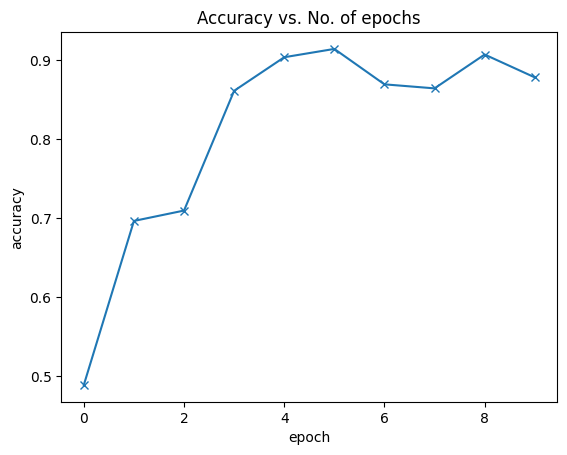

In [44]:
plot_accuracies(history)


In [45]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

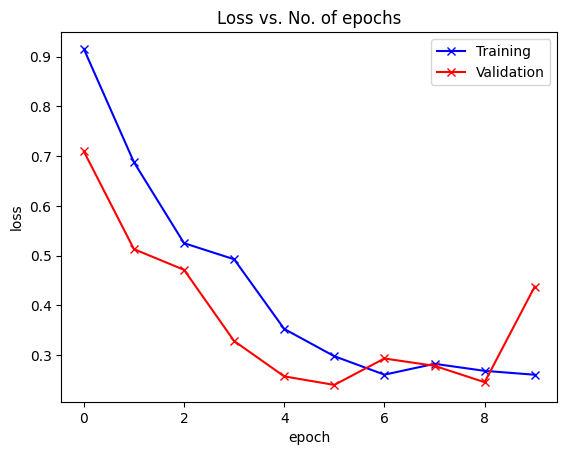

In [46]:
plot_losses(history)

## Testing with individual images

In [47]:
test_dataset = test_ds

In [48]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: water , Predicted: water


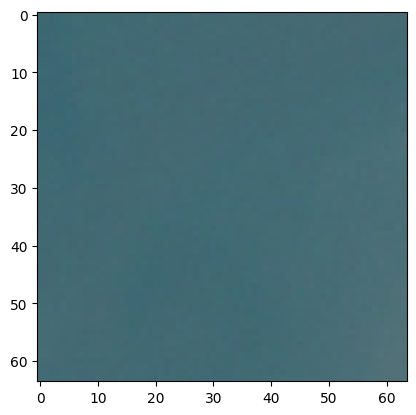

In [50]:
img, label = test_dataset[200]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: green_area , Predicted: green_area


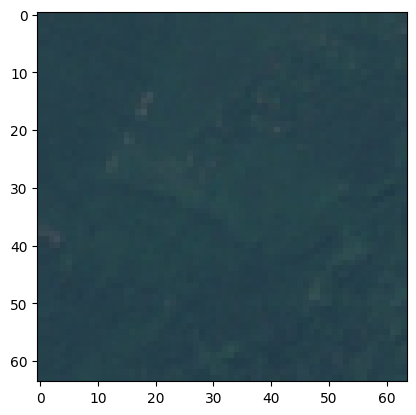

In [51]:
img, label = test_dataset[300]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: desert , Predicted: desert


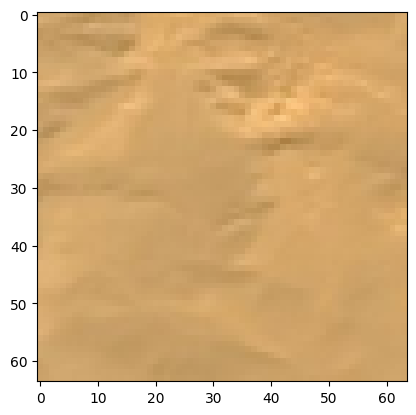

In [52]:
img, label = test_dataset[274]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [53]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.4626721739768982, 'val_acc': 0.8535451889038086}

## Saving and loading the model

In [54]:
torch.save(model.state_dict(), 'satellite-classification-model.pth')

## Conclusion

The project focused on utilizing Deep Learning and Convolutional Neural Networks (CNNs) to automate the classification of satellite images from the Satellite Image Classification Dataset - RSI-CB256. The developed CNN model demonstrated strong performance with a validation accuracy of 85.35% and a validation loss of 0.4627 on the test dataset. This indicates the model's ability to effectively learn and extract meaningful patterns from the images. The successful classification results hold great potential for real-world applications, including land use analysis, environmental monitoring, and disaster management, where automated image interpretation is crucial for efficient decision-making. Further optimization and exploration of different CNN architectures may offer opportunities for enhancing the model's accuracy and generalization capabilities.